# 1. EEG

## 1) 데이터 로드

In [1]:
import numpy as np

# 30초의 수면 데이터 , f3채널
data = np.loadtxt('eeg.txt')

### 데이터 시각화

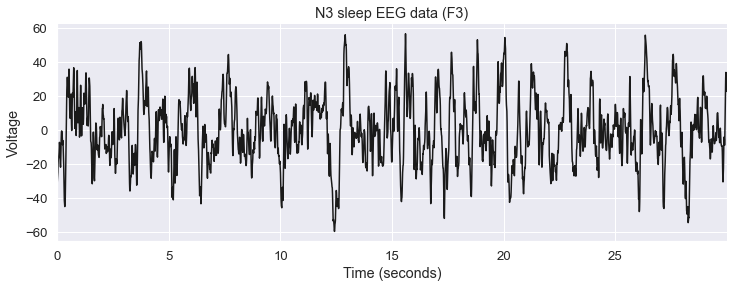

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

#  frequency, time vector 샘플 정의
sf = 100. #샘플링 주파수= 100hz
time = np.arange(data.size) / sf 

# 시그널 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('N3 sleep EEG data (F3)')
sns.despine()

## 2) power spectral 계산 함수

Welch's periodogram: 중복과 상관 없이 연속 푸리에 변환을 평균화함
- periodogram의 작은 윈도우를 이용해 정확도를 향상시킴

eeg 데이터는 항상 시차가 있음-> 이전의 periodogram 분석 방법은 정지상태일때의 추정치 반환=> 편향되어있거나 너무 많은 분산을 포함함

In [3]:
def bandpower(data, sf, band, window_sec=None, relative=False):
# 특정 주파수 대역* 신호의 평균 파워를 계산한다
    """
파라미터
----------
# data : 1d-array // 시간영역에 대한 인풋 신호
# sf : float // 데이터의 샘플링 주파수
# band : list // 관심 대역의 상한, 하한 주파수
# method : string // Periodogram method: 'welch' 또는 'multitaper'
# window_sec : float // second의 윈도우의 길이 
    If None, window_sec = (1 / min(band)) * 2
    
#relative : boolean
    If True, 상대 전력 반환 (= 신호의 총 전력으로 나눈 값).
        If False (default), 절대 전력 반환
반환값
---------
    bp : float// 절대 또는 상대 대역의 파워
    """
    
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # 윈도우 길이 정의
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Welch's periodogram방식으로 파워 스팩트럼 밀도 추정치 계산
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # 주파수 벡터에서 대역에 가장 가까운 인덱스 찾기
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Simpson's rule을 사용한 스펙트럼 적분 근사
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

## 3) 파워스팩트럼 계산

In [4]:
# Delta : 0.5 ~ 4 Hz
# Theta : 4 ~ 7 Hz
# Alpha : 8 ~ 12 Hz
# SMR : 12~15 Hz
# Beta: 15 ~ 18 Hz
# high Beta: 18~ Hz

# 절대 파워에 기반한 계산
db = bandpower(data, sf, [0.5, 4], None)

# 상대 파워에 기반한 계싼
db_rel = bandpower(data, sf, [0.5, 4], None, True)

print('Delta (absolute): %.3f' %db)
print('Delta(relative): %.3f' %db_rel)

Delta (absolute): 321.064
Delta(relative): 0.787


# 2. ECG

In [5]:
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

## 1) 데이터 로드

In [6]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

#ECG센서의 샘플 주파수
settings = {}
settings['fs'] = 500

# ECG 데이터 로드
df = pd.read_csv("ecg.csv", sep=";", index_col="ms")
rr_manual = np.loadtxt("manual-correction-rr.txt", dtype=int)

### 데이터 시각화

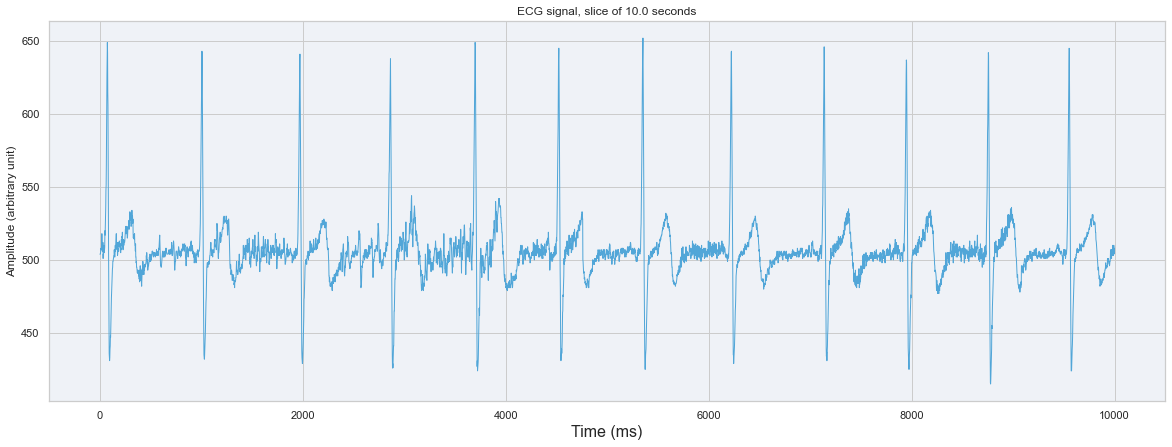

In [7]:
plt.figure(figsize=(20, 7))
start = 0
stop = 5000
duration = (stop-start) / settings['fs']
plt.title("ECG signal, slice of %.1f seconds" % duration)
plt.plot(df[start:stop].index, df[start:stop].heartrate, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

## 2) peak 찾기
(cross corrrelation와 threshold 사용 )

In [8]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    if qrs_filter is None:
        # 사인함수로 QRS 필터 생성
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    #  cross correlation 계산
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # 임계값 이상일때 peak반환
    return ecg_signal[similarity > threshold].index, similarity

In [9]:
def get_plot_ranges(start=10, end=20, n=5):
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

C:\Users\jsm36\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jsm36\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jsm36\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jsm36\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jsm36\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jsm36\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49457 missing from c

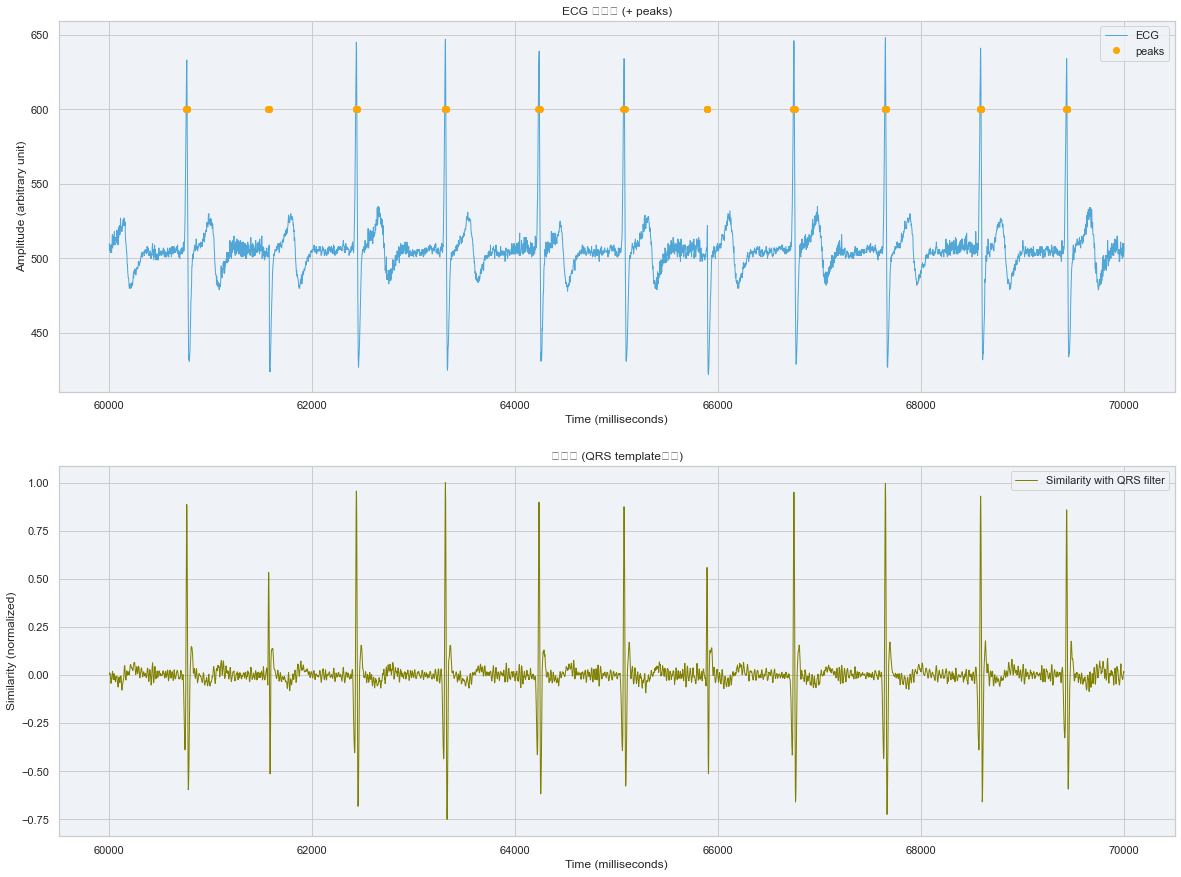

In [10]:
sampfrom = 60000
sampto = 70000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df.index >= start) & (df.index < stop) 
    ecg_slice = df.heartrate[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG 시그널 (+ peaks)")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(600, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('유사성 (QRS template과의)')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")

### 유사한 peak 그룹화

In [11]:
def group_peaks(p, threshold=5):
    output = np.empty(0)

    # 동일한 피크에 속하는 표본 그룹 레이블
    peak_groups, num_groups = label(np.diff(p) < threshold)

    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

### RR구간: 연속 피크의 차이

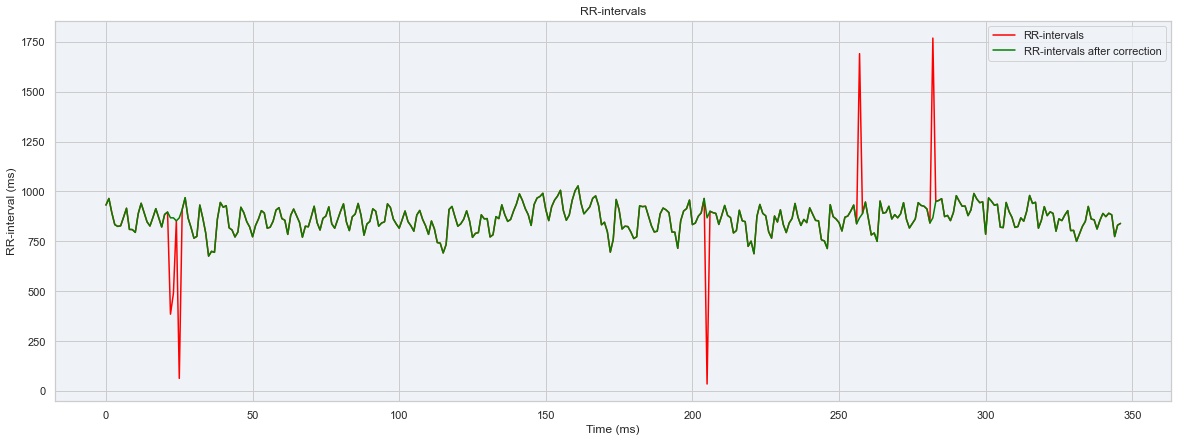

In [12]:
# peak 찾기
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# 그룹 peak를 이용해서 비트당 각각의 peak를 얻을수 있다
grouped_peaks = group_peaks(peaks)

# RR간격은 연속 피크의 차이
rr = np.diff(grouped_peaks)

plt.figure(figsize=(20, 7))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

## 3) RMSSD계산

 RMSSD (Root Mean Square of the Successive Differ- ences) 인접한 NN간격의 차이에 대한 제곱의 합을 평균하여 이에 대한 제곱근으로 표현한 것

교감신경 활성화-> 스트레스, 흥분 상태, 심장박동 증가
부교감신경 활성화-> 휴식, 소화, 회복, 심장박동 감소
교감과 부교감 신경의 조화-> 어떠한 이유로 방해를 받으면 편차가 변경됨
정상 심박동 사이에 연속되는 차이값들의 RMS(root mean square) 값 (낮으면 스트레스및 질병과 관련있다)

<"HRV"을 나타내는 점수로 사용됨>

- Mean RR: 평균 RR 구간
- SDNN: RR 구간의 표준 편차 (건강할수록 값이 큼-> 불규칙하고 복잡한 변화)
- Mean HR: 평균 심박수(heartrate) 분당 비트수로 측정
- STD HR: 심박수의 표준 편차
- Min HR: 최소 심박수
- Max HR: 최대 심박수
- NN50: 50ms이상 차이나는 RR간격. 
- PNN50:  NN50을 총 RR간격으로 나눈것

In [13]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['SDNN STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NN50'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNN50 (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [14]:
print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(rr).items():
    print("- %s: %.2f" % (k, v))

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 864.31
- SDNN STD RR/SDNN (ms): 114.49
- Mean HR (Kubios' style) (beats/min): 69.42
- Mean HR (beats/min): 77.11
- STD HR (beats/min): 100.24
- Min HR (beats/min): 33.92
- Max HR (beats/min): 1714.29
- RMSSD (ms): 147.30
- NN50: 132.00
- pNN50 (%): 38.04


## 4) 주파수 도메인 측정

- LF (low frequency)는 교감신경계와 부교감신경계의 활동 동시에 반영 대부분 교감신경계
(스트레스의 증가 -> LF의 증가)
- HF (high frequency)는 부교감신경계의 활동에 관한 지표, 심장의 전기적인 안정도

In [15]:
x = np.cumsum(rr_manual) / 1000.0
f = interp1d(x, rr_manual, kind='cubic')

fs = 4.0
steps = 1 / fs

xx = np.arange(1, np.max(x), steps)
rr_interpolated = f(xx)

In [16]:
def frequency_domain(rri, fs=4):
    # Welch's 방법으로 스펙트럼 밀도 추정
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # 스팩트럼 밀도를 통합해 각 대역의 power 계산
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    total_power = vlf + lf + hf

    #각 대역에서 어떤 주파수가 가장큰 power를 갖고 있는지 찾음
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [17]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 541.45
- Power LF (ms2): 581.36
- Power HF (ms2): 1873.23
- Power Total (ms2): 2996.04
- LF/HF: 0.31
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.14
- Peak HF (Hz): 0.17
- Fraction LF (nu): 23.68
- Fraction HF (nu): 76.32


## 3. 효율성 분석 모델

### 1) 집중도 분석 (EEG, ECG 이용)

In [18]:
#1. EEG (theta/alpha)
# 집중시 세타파 증가, 알파파 감소 

theta_rel = bandpower(data, sf, [4, 7], None, True)
alpha_rel= bandpower(data, sf, [8, 12], None, True)

atten= (theta_rel/alpha_rel)

print('Theta/Alpha(relative): %.3f' %(atten))

Theta/Alpha(relative): 0.971


In [20]:
# 2. EEC
#  SDNN(wight : 4) >> RMSSD(wight :3) > LF/HF(wight: 2)  > NN50(wight:1)
SDNN= np.std(rr)
RMSSD=np.sqrt(np.mean(np.square(np.diff(rr))))

fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
cond_lf = (fxx >= 0.04) & (fxx < 0.15)
cond_hf = (fxx >= 0.15) & (fxx < 0.4)
lf = trapz(pxx[cond_lf], fxx[cond_lf])
hf = trapz(pxx[cond_hf], fxx[cond_hf])
LF_HF=(lf/hf)

NN50= np.sum(np.abs(np.diff(rr)) > 50)*1

print("SDNN: %.2f"% SDNN)
print("RMSSD: %.2f"% RMSSD)
print("LF/HF: %.2f"% LF_HF)
print("NN50: %.2f"% NN50)

SDNN: 114.49
RMSSD: 147.30
LF/HF: 0.31
NN50: 132.00


### 2) 스트레스 분석 (ECG, 스마트 워치 이용)

In [21]:
#1, 스트레스 상황: SDNN 증가, LF(큰폭 증가)
print("SDNN: %.2f"% SDNN)
lf_nu = 100 * lf / (lf + hf)
print("LF: %.2f"% lf_nu)

SDNN: 114.49
LF: 23.68


In [22]:
#2. 스마트 워치 활용
stress=input("측정된 스트레스 지수 입력하시오(0-100): ")
stress= float(stress)

측정된 스트레스 지수 입력하시오(0-100): 50


### 3) 불안요소 반영

In [23]:
p= atten*0.5 + (SDNN*0.4)+(RMSSD*0.3)+(LF_HF*0.2)+(NN50*0.1)- lf_nu - stress*0.1
print(p)

75.04969292775613


In [24]:
#대면수업
contact= p-(14.2*0.7+38*0.3)

In [25]:
#비대면 수업
uncon= p- (0.042+0.12+0.32+0.21+0.142+0.68)*10

### 4) 계산 모델 

In [26]:
#대면수업
print("대면수업의 효율은: %.2f점이다" %contact)

#비대면 수업
print("비대면수업의 효율은: %.2f점이다" %uncon)
print("\t")
if contact>uncon:
    print("그러므로, 대면수업을 하는것이 더 좋다")
elif uncon>contact:
    print("그러므로, 비대면수업을 하는것이 더 좋다")
else:
    print("그러므로, 대면과 비대면 수업이 비슷한 효율을 낸다")

대면수업의 효율은: 53.71점이다
비대면수업의 효율은: 59.91점이다
	
그러므로, 비대면수업을 하는것이 더 좋다
